In [2]:
from utils.model import *
from utils.load_data import *
from config import config
from pickle import load
import random
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# Random seed
random.seed(1035)

In [6]:
# Load the dataset (img.jpg, list of captions)
#captions = getAllCaptions(config)

In [5]:
# Load the training data
images_features_train, captions_train = load_image_features(config, 'train'), load_clean_data(config, 'train')

Train images: 6000.
Done!
Train images: 6000.


In [8]:
# Load the validation data
images_features_val, captions_val = load_image_features(config, 'dev'), load_clean_data(config, 'dev')

Dev images: 1000.
Done!
Dev images: 1000.


In [6]:
# Tokenization
tokenizer = create_tokenizer(captions_train)
max_len = max_length(captions_train)
print(f"Max length: {max_len}")
vocab_size = len(tokenizer.word_index) + 1
print(f"Train vocab size: {vocab_size}")

Max length: 34
Train vocab size: 7579


In [12]:
# Define the model
model = define_model(vocab_size, max_len)
print('RNN Model summary:')
print(model.summary())

RNN Model summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 256)      1940224     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['input_3[0][0]']                
                                                                         

In [9]:
# Train the model and save after each epoch
epochs = 20
batch_size = 64

# Calculate steps

# Train step
steps_train = len(captions_train)//batch_size
if len(captions_train)%batch_size!=0:
    steps_train = steps_train+1

# Val step
steps_val = len(captions_val)//batch_size
if len(captions_val)%batch_size!=0:
    steps_val = steps_val+1

# Checkpoints
model_save_path = "./model_data/model_RNN_epoch-{epoch:02d}_train_loss-{loss:.4f}_val_loss-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]

# Display infos
print('steps_train: {}, steps_val: {}'.format(steps_train,steps_val))
print('Batch Size: {}'.format(batch_size))
print('Total Number of Epochs: {}'.format(epochs))

# Shuffle train data
ids_train = list(captions_train.keys())
random.shuffle(ids_train)
captions_train_shuffled = {_id: captions_train[_id] for _id in ids_train}
caps_train = captions_train_shuffled

steps_train: 94, steps_val: 16
Batch Size: 64
Total Number of Epochs: 20


In [11]:
# Create the train data generator
# returns [[img_features, text_features], out_word]
generator_train = data_generator(images_features_train, caps_train, tokenizer, max_len, batch_size, 1035)
# Create the validation data generator
# returns [[img_features, text_features], out_word]
generator_val = data_generator(images_features_val, captions_val, tokenizer, max_len, batch_size, 1035)

# Fit for one epoch
model.fit(generator_train, epochs=epochs, steps_per_epoch=steps_train, validation_data=generator_val, validation_steps=steps_val, callbacks=callbacks, verbose=1)


2023-05-30 05:10:47.919666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 5.6360

2023-05-30 05:16:46.555089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 4.86529, saving model to ./model_data/model_RNN_epoch-01_train_loss-5.6360_val_loss-4.8653.hdf5
94/94 [==============================] - 399s 4s/step - loss: 5.6360 - val_loss: 4.8653
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 4.4692
Epoch 2: val_loss improved from 4.86529 to 4.16248, saving model to ./model_data/model_RNN_epoch-02_train_loss-4.4692_val_loss-4.1625.hdf5
94/94 [==============================] - 335s 4s/step - loss: 4.4692 - val_loss: 4.1625
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 3.8869
Epoch 3: val_loss improved from 4.16248 to 3.93021, saving model to ./model_data/model_RNN_epoch-03_train_loss-3.8869_val_loss-3.9302.hdf5
94/94 [==============================] - 333s 4s/step - loss: 3.8869 - val_loss: 3.9302
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 3.5767
Epoch 4: val_loss improved from 3.93021 to 3.84140, saving model to ./model_data/model_RNN_epoch-

In [13]:
model.load_weights('./model_data/model_RNN_epoch-05_train_loss-3.3597_val_loss-3.8173.hdf5')

In [14]:
# Load test data
images_features_test, captions_test = load_image_features(config, 'test'), load_clean_data(config, 'test')

Test images: 1000.
Done!
Test images: 1000.


In [19]:
#Evaluate the model on test data data and ouput BLEU score

print(('Evaluation'), end='\n')
print('Calculating BLEU score for test data:')
evaluate_model(model, images_features_val, captions_val, tokenizer, max_len)

Evaluation
Calculating BLEU score for test data:


100%|██████████| 1000/1000 [12:12<00:00,  1.37it/s]


BLEU Scores :
THe closer to 1 the better
BLEU-1: 0.456858
BLEU-2: 0.280111
BLEU-3: 0.207527
BLEU-4: 0.103957


# Testing on some images

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

In [16]:
# Extract features from each image in the directory
def extract_features(filename, model):
	# Loading and resizing image
	image = load_img(filename, target_size=(224,224))
	# Convert the image pixels to a numpy array
	image = img_to_array(image)
	# Reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# Prepare the image for the CNN Model model
	image = preprocess_input(image)
	# Pass image into model to get encoded features
	features = model.predict(image, verbose=0)
	return features

In [25]:
# Setting the max length: here the max length is set manually
max_len_test = 34

In [18]:
def image_model():	
    network = VGG16()
    network = Model(inputs=network.inputs, outputs=network.layers[-2].output)
    return network

In [19]:
img_model = image_model()

In [73]:
# Show image and its caption

def plot_result(filename):

    print(f"Generating caption for image {filename}")
    image_features = extract_features(filename, img_model)
    generated_caption = generate_caption(model, tokenizer, image_features, max_len_test)
    print('Done!')

    cap = generated_caption.split()
    cap = cap[1:-1]
    cap = ' '.join(cap)

    im = Image.open(filename, 'r')

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.imshow(np.asarray(im))
    ax.set_title("\n{}\n".format(cap))

    return cap


Generating caption for image ./testing_samples/mountain.jpg
Done!


'man is standing on the mountains in the air'

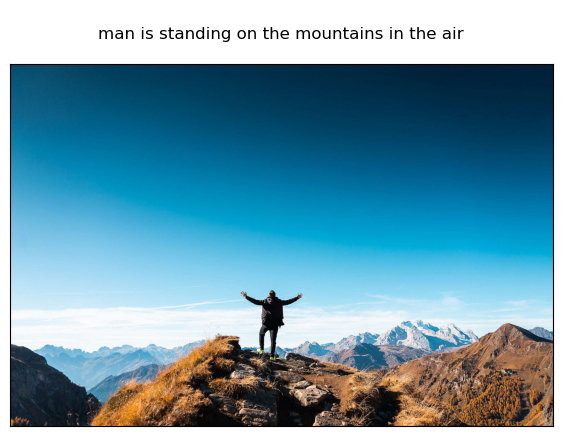

In [74]:
plot_result('./testing_samples/mountain.jpg')

Generating caption for image ./testing_samples/football.jpg
Done!


'two men are playing in the field'

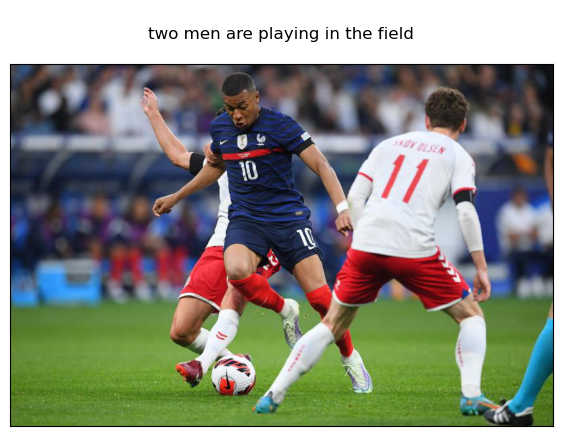

In [76]:
plot_result('./testing_samples/football.jpg')